In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh
signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])
bkg = ObjIter([Tree(module.QCD_B_List, use_gen=False), Tree(module.TTJets, use_gen=False)])

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


In [3]:
(signal+bkg).apply(lambda t : t.extend(
    X_et = np.sqrt(t.X_m**2 + t.X_pt**2),
    jet_ht=sum(ak.unzip(t[[ f'{obj}_ptRegressed' for obj in eightb.quarklist]]))
))

[None, None, None, None, None]

100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


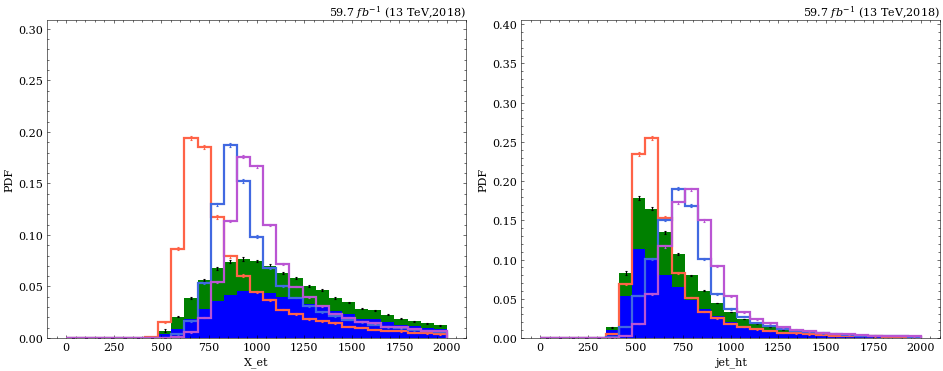

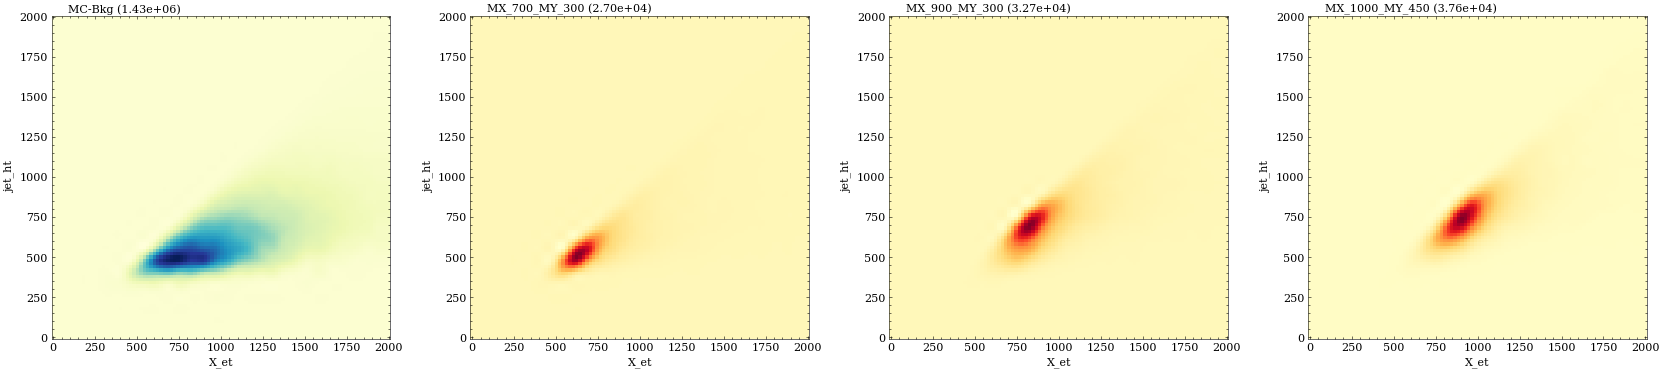

In [6]:
study.quick(
    signal+bkg,
    efficiency=True,
    varlist=['X_et','jet_ht'],
    binlist=[(0,2000,30)]*2,
)

study.quick2d(
    signal+bkg,
    efficiency=True,
    varlist=['X_et','jet_ht'],
    binlist=[(0,2000,30)]*2,
    interp=True,
)


In [7]:
(signal+bkg).apply(lambda t : t.extend(**{
    f'{obj}_ptfrac':t[f'{obj}_ptRegressed']/t.X_et
    for obj in eightb.quarklist
}))

[None, None, None, None, None]

In [13]:
(signal+bkg).apply(lambda t : t.extend(
    jet_htfrac=t.jet_ht/t.X_et
))

[None, None, None, None, None]

In [8]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


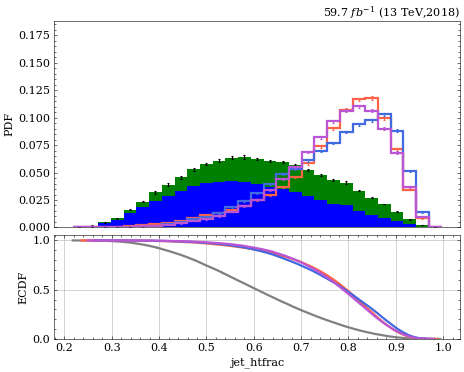

In [18]:
study.quick(
    signal+bkg,
    efficiency=True,
    varlist=['jet_htfrac'],

    empirical=True, e_sf=True, e_size="50%"
    # e_correlation=True, e_c_method=None, e_c_label_stat='area'
)

In [12]:
mask_htfrac = lambda t, v : t.jet_htfrac > v

In [22]:
def compare_masks(var):
    fig, axs = study.get_figax(nvar=4, dim=(-1,4))

    for i in range(3):
        study.quick(
            signal[[i]*4], h_linestyle=[':','-.','--','-'],
            masks=[None]*2+[lambda t : mask_htfrac(t, 0.55)]*2 + [lambda t : mask_htfrac(t, 0.6)]*2 + [lambda t : mask_htfrac(t, 0.68)]*2,
            varlist=[var], legend=True,
            figax=(fig,axs.flat[i])
        )

    study.quick_region(
        bkg, bkg, bkg, bkg, h_color=['grey']*4, label=['MC-Bkg']*4,
        h_linestyle=[':','-.','--','-'],
        masks=[None]*2+[lambda t : mask_htfrac(t, 0.55)]*2 + [lambda t : mask_htfrac(t, 0.6)]*2 + [lambda t : mask_htfrac(t, 0.68)]*2,
        varlist=[var], legend=True,
        figax=(fig,axs.flat[-1])
    )

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


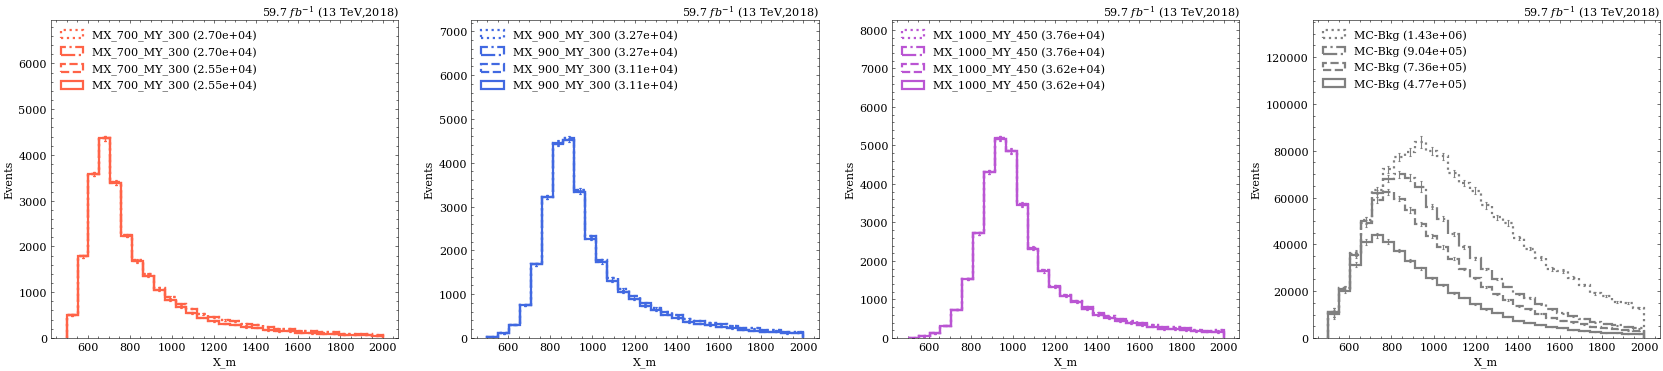

In [23]:
compare_masks('X_m')

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


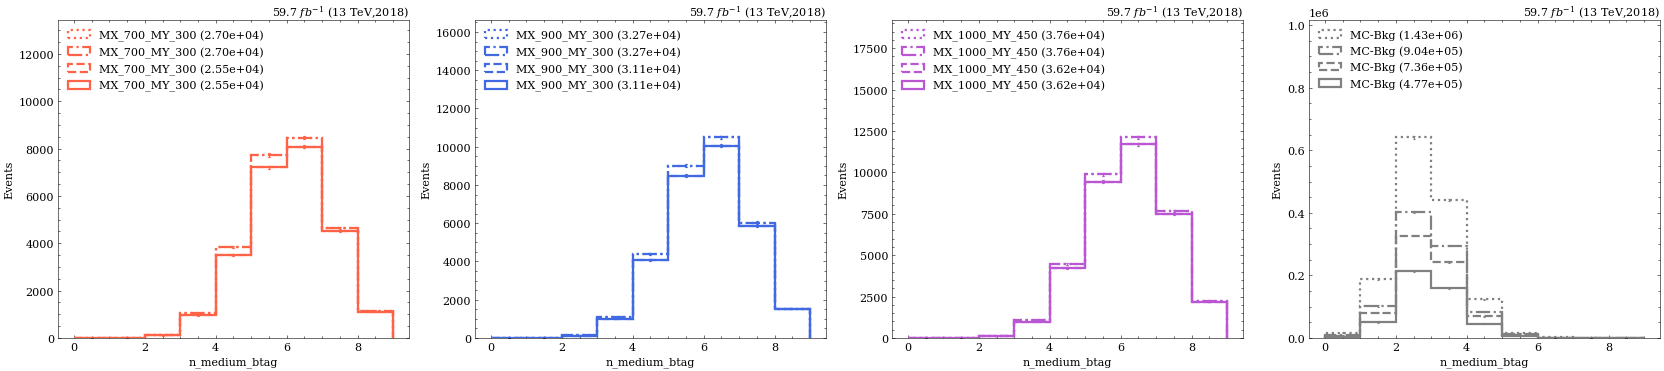

In [24]:
compare_masks('n_medium_btag')

100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


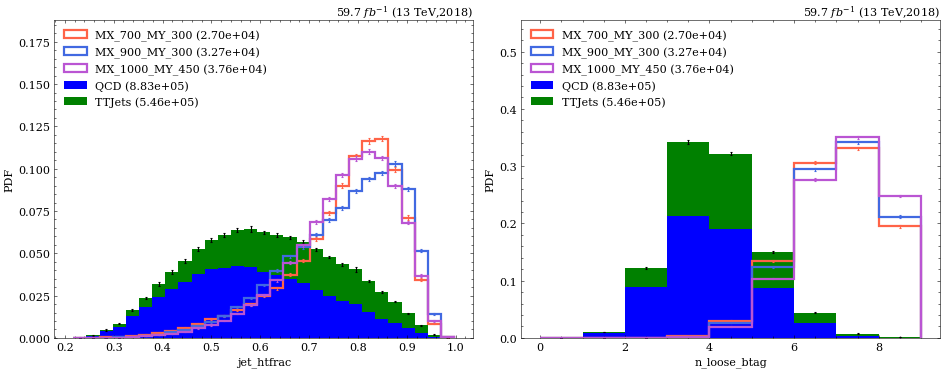

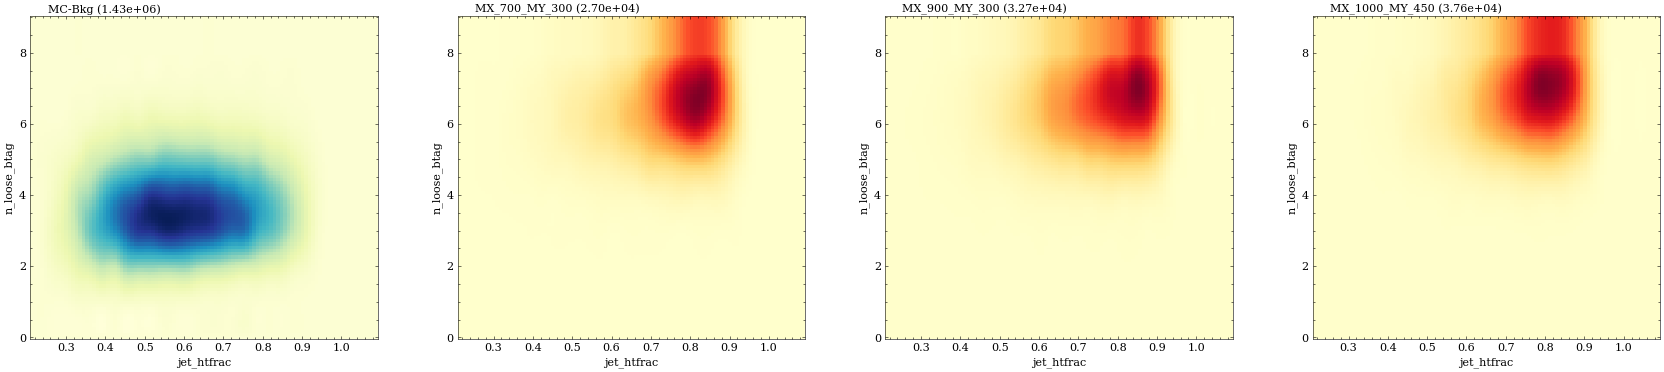

In [26]:
study.quick(
    signal+bkg, legend=True, efficiency=True,
    varlist=['jet_htfrac','n_loose_btag'],
)
study.quick2d(
    signal+bkg, interp=True,
    varlist=['jet_htfrac','n_loose_btag'],
)

100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


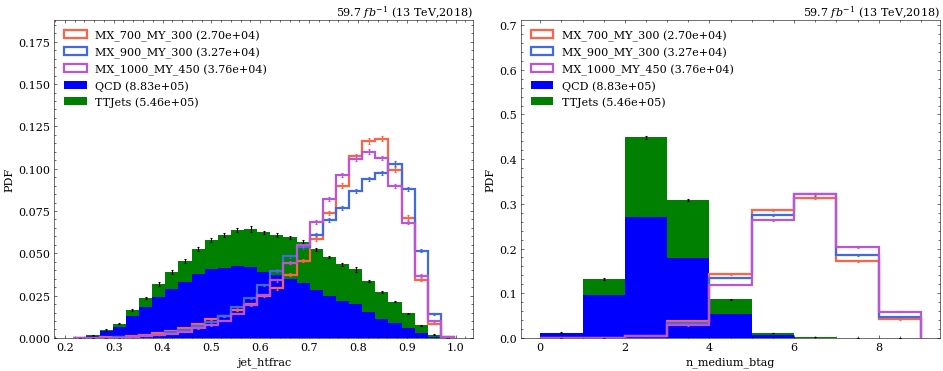

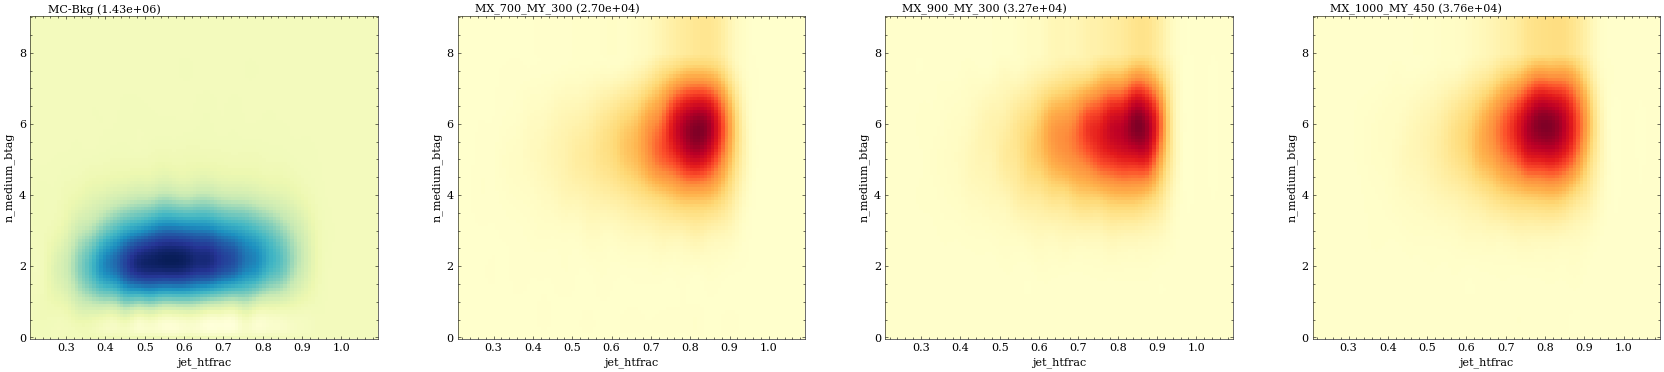

In [25]:
study.quick(
    signal+bkg, legend=True, efficiency=True,
    varlist=['jet_htfrac','n_medium_btag'],
)
study.quick2d(
    signal+bkg, interp=True,
    varlist=['jet_htfrac','n_medium_btag'],
)

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


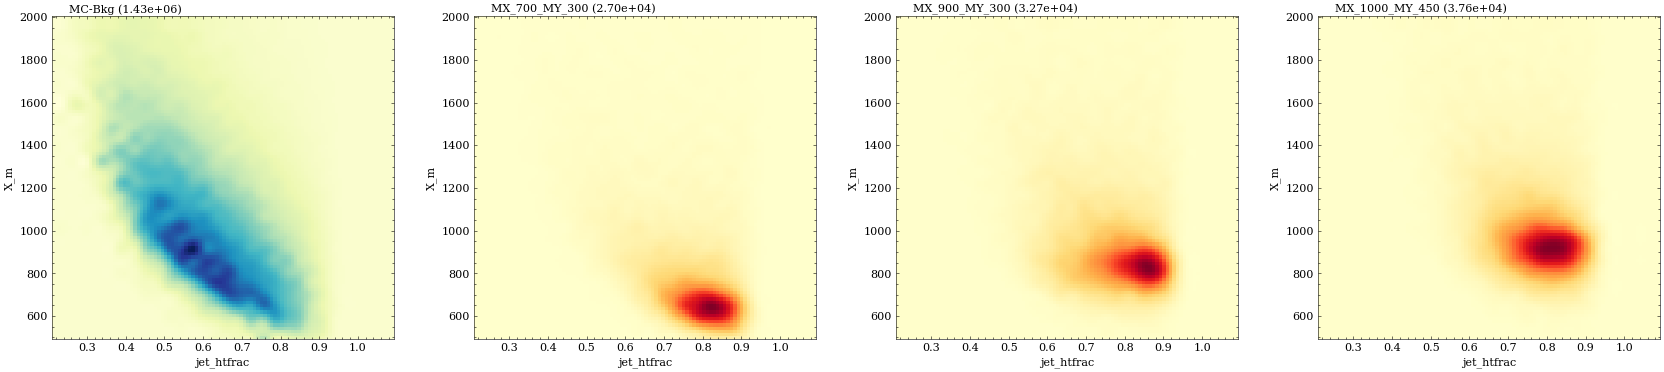

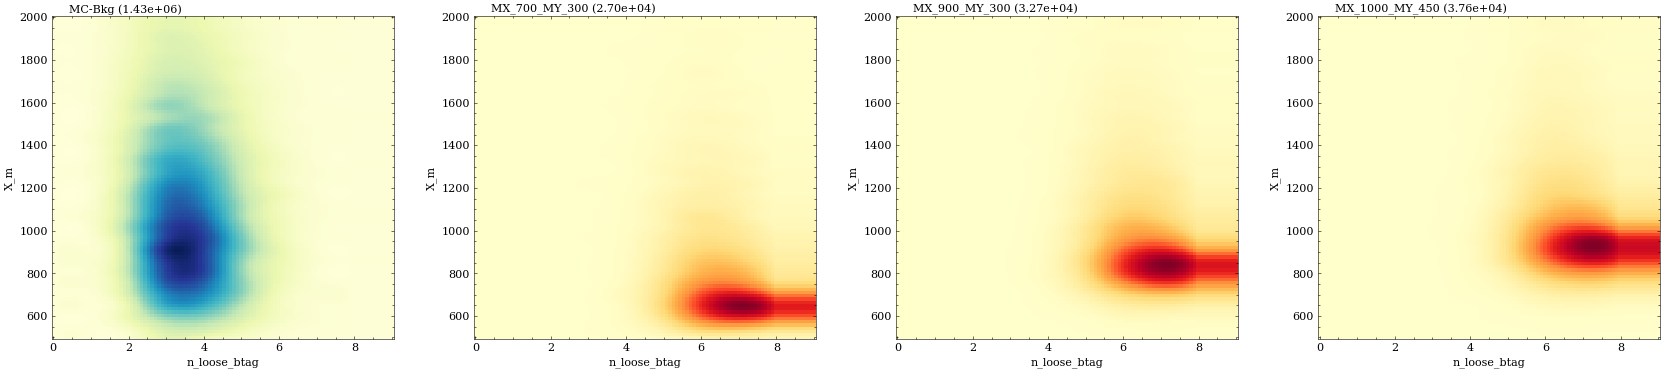

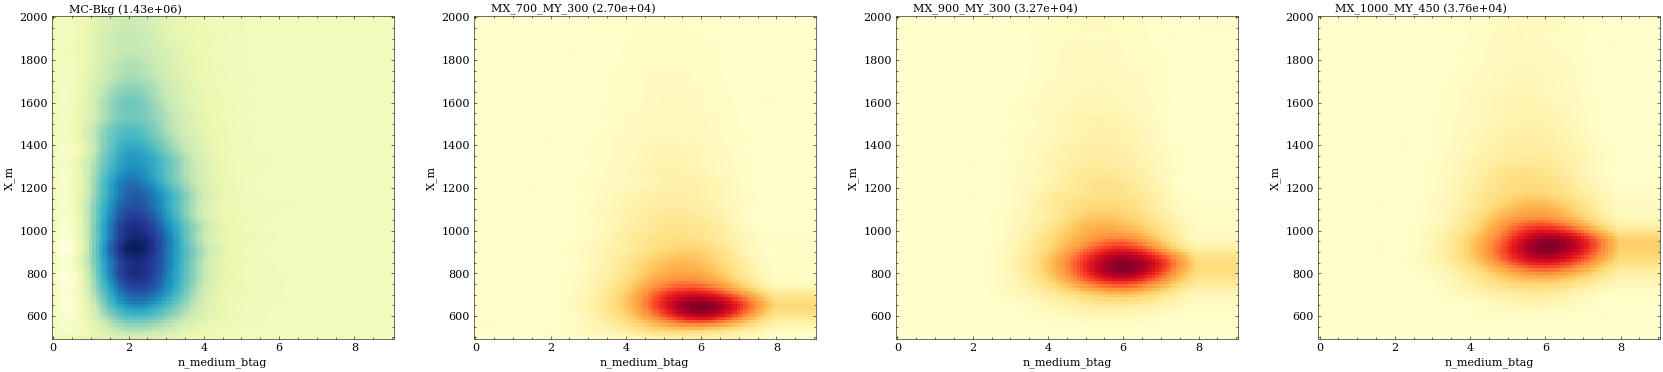

In [27]:
study.quick2d(
    signal+bkg, interp=True,
    varlist=['jet_htfrac','X_m'],
)
study.quick2d(
    signal+bkg, interp=True,
    varlist=['n_loose_btag','X_m'],
)
study.quick2d(
    signal+bkg, interp=True,
    varlist=['n_medium_btag','X_m'],
)

100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


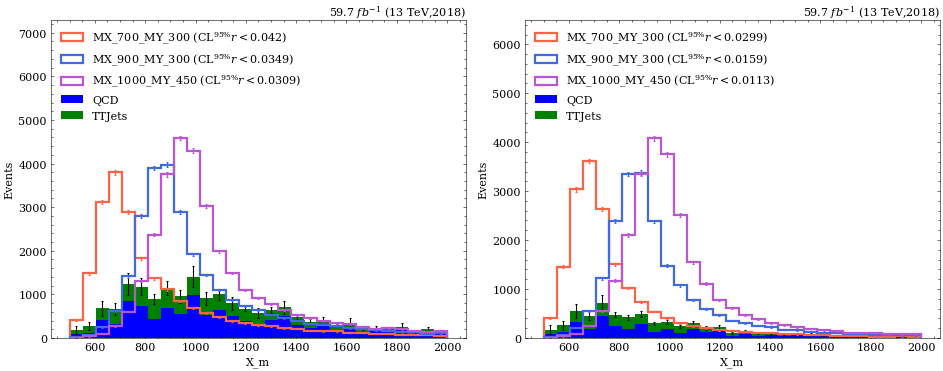

In [81]:
fig, axs = study.get_figax(nvar=2)

histos=obj_store()

study.quick(
    signal+bkg, legend=True,
    masks=lambda t : t.n_medium_btag>4,
    varlist=['X_m'],
    limits=True, store=histos,
    figax=(fig, axs.flat[0]),
)

study.quick(
    signal+bkg, legend=True,
    masks=lambda t : (t.n_medium_btag>4)&(t.jet_htfrac>0.7),
    varlist=['X_m'],
    limits=True, store=histos,
    figax=(fig, axs.flat[1]),
)

In [82]:
ObjIter(histos.objs[0][1:]).zip( ObjIter(histos.objs[1][1:])).apply(lambda hs : float(hs[0].stats.exp_limits[2]/hs[1].stats.exp_limits[2]))

[1.382423219868028, 2.148241941192397, 2.6065721519236207]